In [546]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time
import timeit


In [547]:
# Problem 1

# Create a routine for calculating an exponentially weighted covariance matrix
problem1_df = pd.read_csv("DailyReturn.csv")
problem1_df=problem1_df.rename(columns={"Unnamed: 0": "Date"})

def Cal_weight(lamda,n):
    w=np.zeros(n)
    total_w=0
    for i in range(n):
        tmp=(1-lamda)*pow(lamda,i-1)
        w[i]=tmp
        total_w+=tmp

    w=w/total_w
    return w
    
def Cal_cov(w,x,y):
    n=len(x)
    cov=0
    x_mean=np.mean(x)
    y_mean=np.mean(y)
    
    for i in range(n):
        cov+=(x[i]-x_mean)*(y[i]-y_mean)*w[n-1-i]
    
    return cov

problem1_df2=problem1_df.drop(columns='Date')

def Cal_cov_matrix(lamda,df):
        
    n_assets=df.shape[1]
    n_date=df.shape[0]

    cov_mat=np.zeros((n_assets,n_assets))

    weight=Cal_weight(lamda,n_date)
    cols=df.columns

    for i in range(n_assets):
        x=cols[i]
        cov_mat[i][i]=Cal_cov(weight,df[x],df[x])
        for j in range(i+1,n_assets):
            y=cols[j]
            cov_mat[i][j]=Cal_cov(weight,df[x],df[y])
            cov_mat[j][i]=cov_mat[i][j]
    return np.array(cov_mat)



In [548]:
# PCA
def PCA(cov_mat):
    
    vals,vecs =np.linalg.eigh(cov_mat)
    tv=np.sum(vals)
    
    explain_total=0
    explain_list=[]
    
    for i in vals:
        if i > 0:
            explain_total+=i
            explain_list.append(i)
            
    
   
    exp_list=sorted(explain_list,reverse=True)
    exp_cum_list=np.cumsum(exp_list)
    exp_cum_list=np.divide(exp_cum_list,explain_total)
    
    return exp_cum_list

Text(0.5, 1.0, 'cumulative variance explained by different lambda')

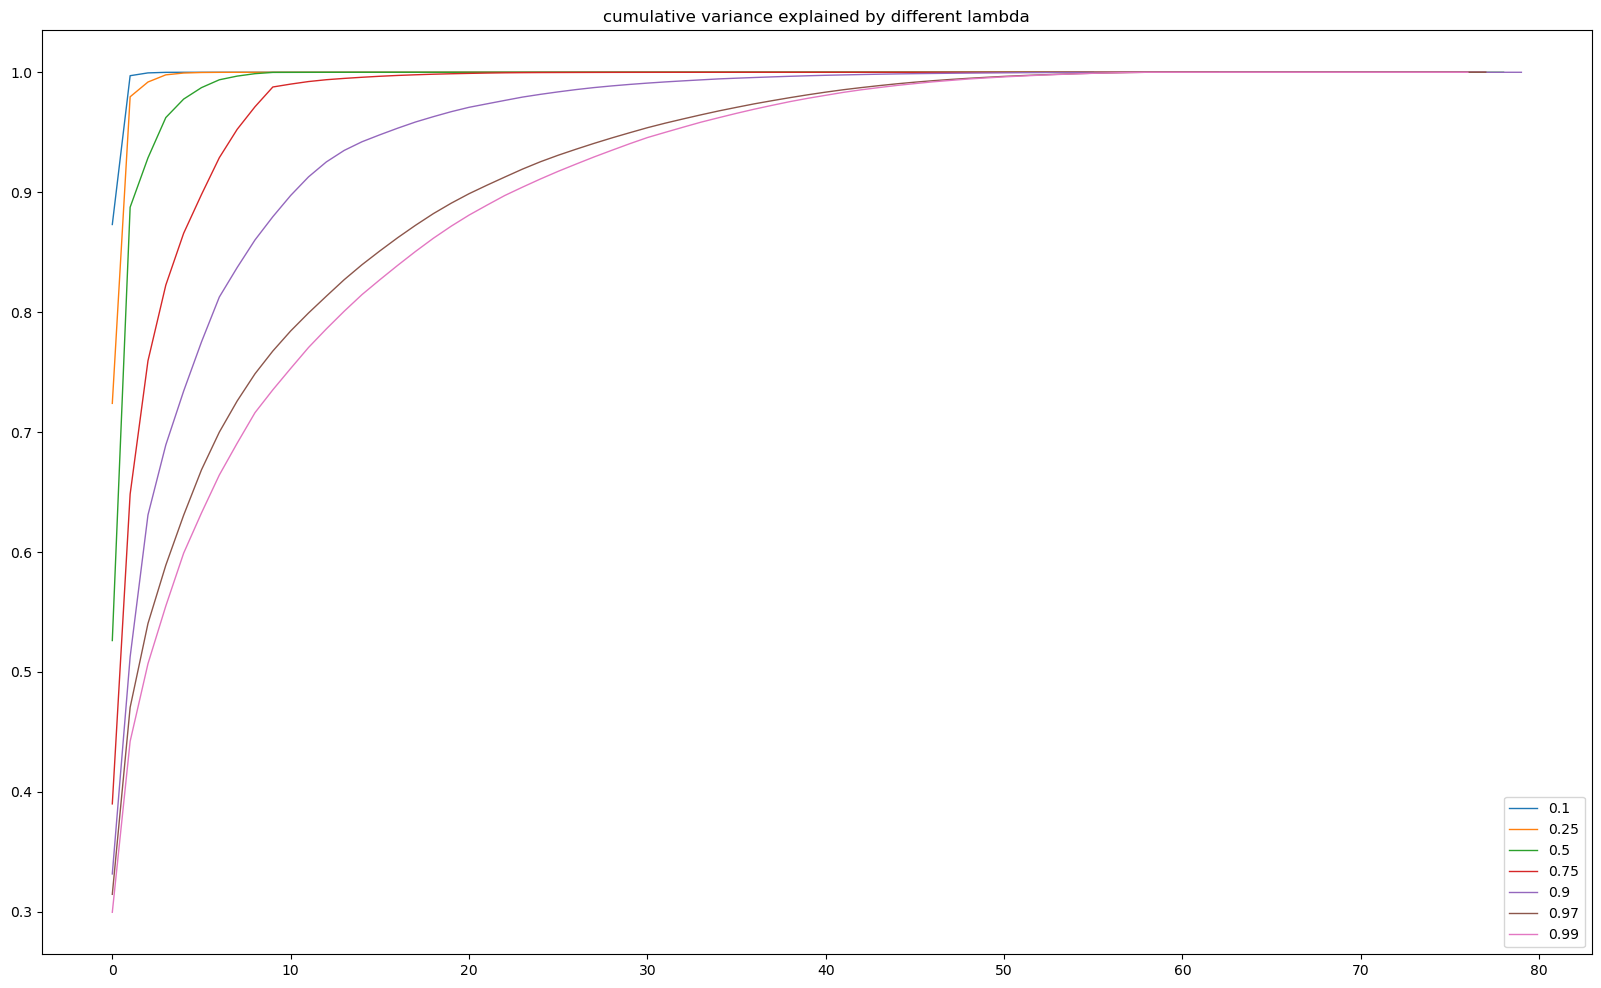

In [563]:
Lambda = [0.1,0.25,0.5,0.75,0.9,0.97,0.99]
n=problem1_df2.shape[0]
plt.figure(figsize=(20,12))

for i in Lambda:
    cov_mat = Cal_cov_matrix(i,problem1_df2)
    y = PCA(cov_mat)
    plt.plot(y,lw=1,ms=4,label=i)

plt.legend()
plt.title("cumulative variance explained by different lambda")

In [580]:
# Problem 2

# implement chol_psd 
def chol_psd(root,a):
    n=len(a)
    
    root=np.zeros((n,n))
    
    for j in range(n):
        if j==0:
            s=0
        else:
            s=np.matmul(root[j,:j],root[j,:j].T)
    
        temp=a[j,j]-s
        if 0 >= temp >= -1e-8:
            temp = 0.0
            
        root[j,j]=np.sqrt(temp)
        
        if root[j,j]==0:
            continue
        
        ir=1.0/root[j,j]
        
        for i in range((j+1),n):
            s=np.matmul(root[i,:j],root[j,:j]) 
            root[i,j]=(a[i,j]-s)*ir
                      
    return root

#implement near_psd:

def near_psd(a,epsilon=0.0):
    
    n=len(a)
    
    invSD=np.array([])
    out=a.copy()
    
    if np.count_nonzero(np.diag(a)==1) !=n:
        invSD=np.diagflat(1/np.sqrt(np.diag(out)))
        tmp=np.matmul(out,invSD)
        out=np.matmul(invSD,tmp)
        
    vals,vecs=np.linalg.eigh(a)
    vals=np.maximum(vals,epsilon)
    temp=np.matmul(vecs,vecs)
    T=1/np.matmul(vecs*vecs,vals)
    T=np.diagflat(np.sqrt(T))
    l=np.diagflat(np.sqrt(vals))
    tmp2=np.matmul(T,vecs)
    B=np.matmul(tmp2,l)
    out=np.matmul(B,B.T)
    
    if len(invSD) != 0:
        invSD = np.diagflat(1/np.diag(invSD))
        tmp3=np.matmul(out,invSD)
        out=np.matmul(invSD,tmp3)
        
    return out


In [551]:
# Implement Higham 2002


def ProjectionU(A):
    p=A.copy()
    
    for i in range(len(A)):
       p[i,i]=1
    return p

def ProjectionS(A,W):
    w_sqrt=np.sqrt(W)
    tmp=np.matmul(w_sqrt,A)
    
    tmp2=np.matmul(tmp,w_sqrt)
    
    vals , vecs = np.linalg.eigh(A)
    vals = np.maximum(vals,0)
    val_diag= np.diagflat(vals)
    
    tmp=np.matmul(vecs,val_diag)
    p=np.matmul(tmp,vecs.T)
    
    return p

def Frobenius_Norm(A):
    tot=0
    for i in range(len(A)):
        for j in range(len(A)):
            tot+=A[i,j]**2
            
    return tot


def Higham_2002(A,iteration=1000):
    Lag_deltaS = 0
   
    Lag_Y = A
    
    Lag_Gamma = np.inf
    
    weights=np.ones(len(A))
    
    tol = 1e-10
    
    for i in range(iteration):
        R = Lag_Y - Lag_deltaS
        X=ProjectionS(R,weights)
        deltaS=X-R
        Y=ProjectionU(X)
        Gamma=Frobenius_Norm(Y-A)
        
        if abs(Gamma - Lag_Gamma)<tol:
            break
        
        Lag_deltaS=deltaS
        Lag_Y=Y
        Lag_Gamma=Gamma
        
    return Y
    



In [552]:
# generate NON PSD
    
def gen_non_psd(n):
    sigma = np.full((n,n),0.9)
    for i in range(n):
        sigma[i,i]=1
    
    sigma[0,1] = 0.7357
    sigma[1,0] = 0.7357 
    return sigma

In [565]:
# Judge if the matrix is PSD
def if_PSD(A):
    vals,vecs=np.linalg.eigh(A)
    n=len(A)
    vals=sorted(vals)
    
    if vals[0]>-1e-8:
        print("The fixed matrix is PSD")
    else:
        print("The fixed matrix is not PSD")

if_PSD(near_psd(gen_non_psd(500)))
if_PSD(Higham_2002(gen_non_psd(500)))

The fixed matrix is PSD
The fixed matrix is PSD


In [567]:
# Compare the results of both using the Frobenius Norm.


def compare_run_time(n):
    non_psd=gen_non_psd(n)
    print("When N= "+str(n)+", the run time of each is shown below:")
    n1 = time.time()
    npsd = near_psd(non_psd)
    n2 = time.time()
    near_t = n2 - n1
    
    h1 = time.time()
    higham = Higham_2002(non_psd)
    h2 = time.time()
    higham_t = h2 - h1
   
    print("The run time of near psd is "+str(near_t))
    print("The run time of higham2002 is "+ str(higham_t))
    return near_t,higham_t
    
    
def compare_Frob_Norm(n):
    non_psd=gen_non_psd(n)
    print("When N= "+str(n)+", the result of Frobenius Norm of each is shown below:")
    near_psdA=near_psd(non_psd)
    near_frobA=Frobenius_Norm(near_psdA-non_psd)

    higham_psdA=Higham_2002(non_psd)
    higham_frobA=Frobenius_Norm(higham_psdA-non_psd)
    
    print("The result of Frobenius Norm of near psd is "+str(near_frobA))
    print("The result of Frobenius Norm of higham2002 is "+str(higham_frobA))
    return near_frobA,higham_frobA


When N= 10, the run time of each is shown below:
The run time of near psd is 0.0
The run time of higham2002 is 0.0019996166229248047
When N= 10, the result of Frobenius Norm of each is shown below:
The result of Frobenius Norm of near psd is 0.0027385481538506153
The result of Frobenius Norm of higham2002 is 0.0015192331193787274
When N= 100, the run time of each is shown below:
The run time of near psd is 0.0030014514923095703
The run time of higham2002 is 0.21969389915466309
When N= 100, the result of Frobenius Norm of each is shown below:
The result of Frobenius Norm of near psd is 0.07441520643491044
The result of Frobenius Norm of higham2002 is 0.007164374540474617
When N= 250, the run time of each is shown below:
The run time of near psd is 0.005002498626708984
The run time of higham2002 is 0.9715790748596191
When N= 250, the result of Frobenius Norm of each is shown below:
The result of Frobenius Norm of near psd is 0.19418590463141075
The result of Frobenius Norm of higham2002 

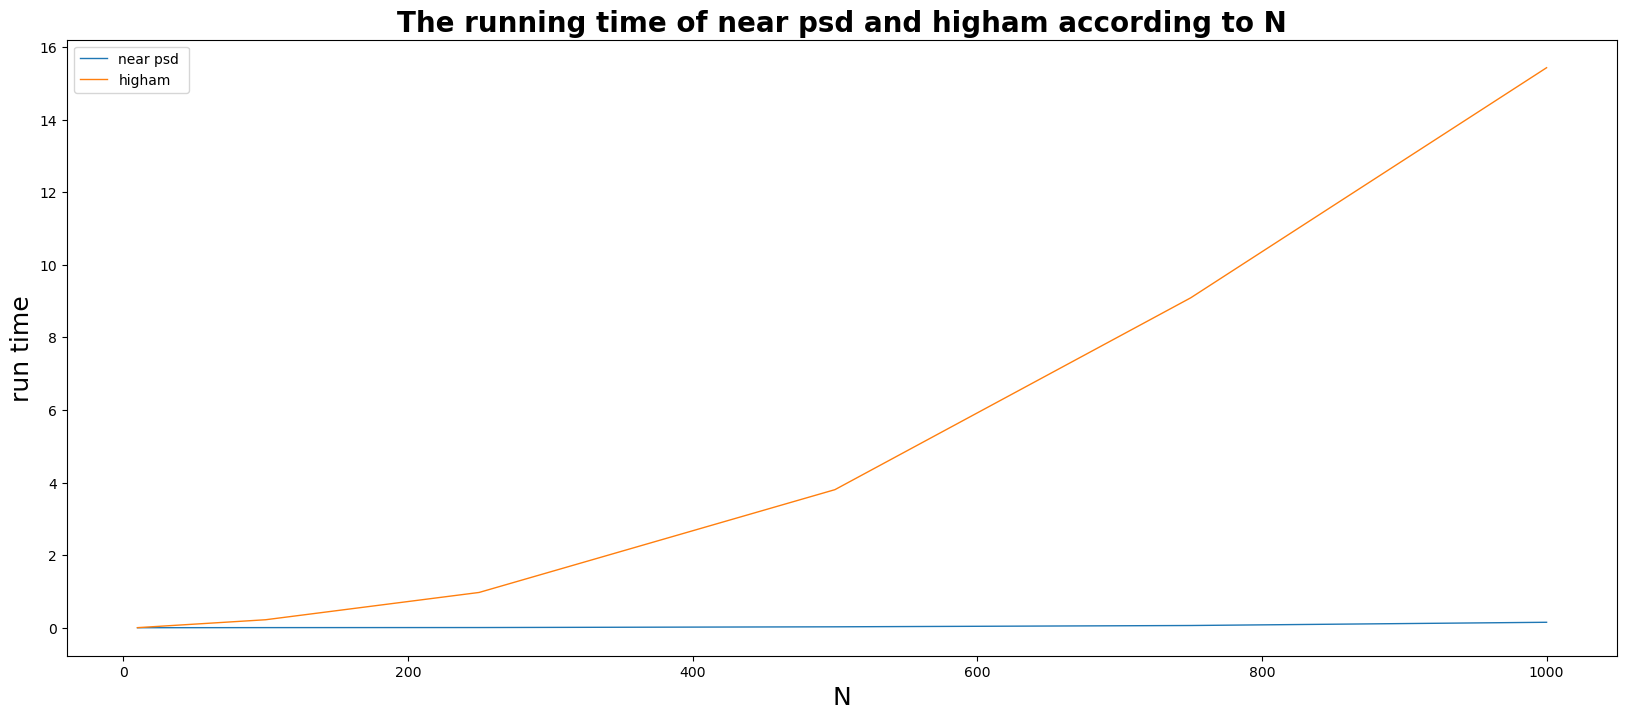

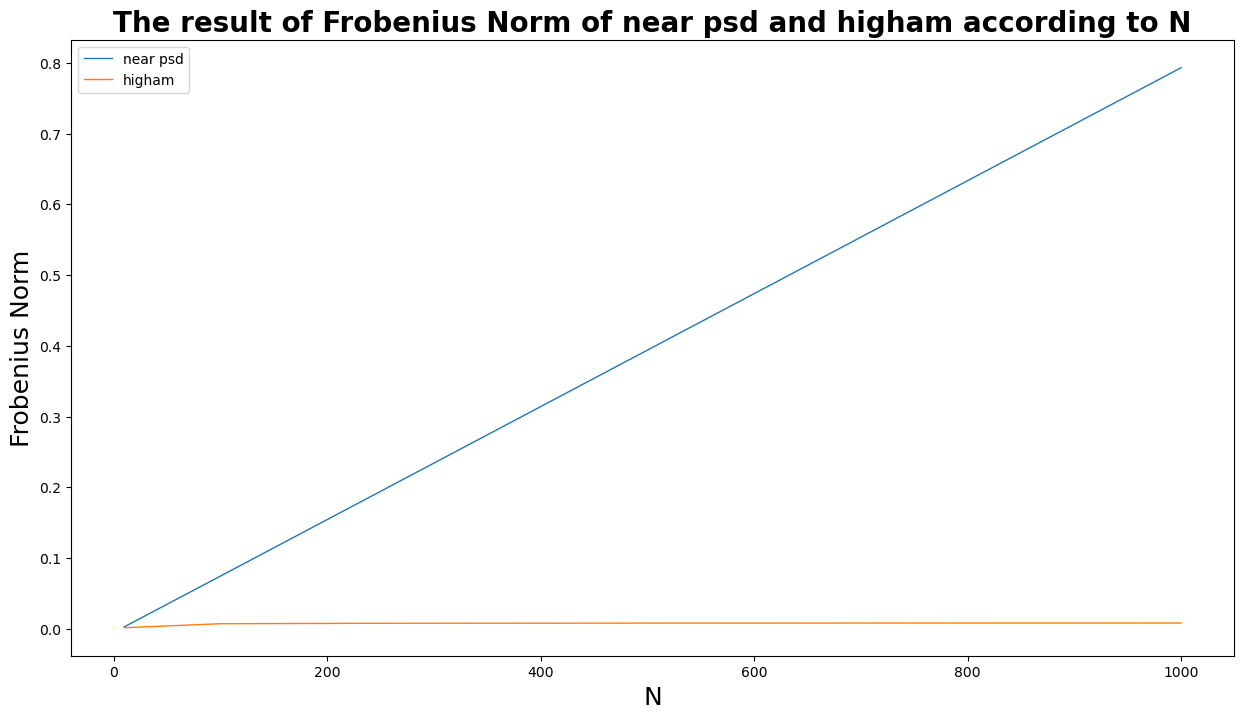

In [568]:
N=[10,100,250,500,750,1000]
near_time=[]
near_f=[]
high_time=[]
high_f=[]

for i in N:
    n_t,h_t=compare_run_time(i)
    n_f,h_f=compare_Frob_Norm(i)
    near_time.append(n_t)
    near_f.append(n_f)
    high_time.append(h_t)
    high_f.append(h_f)

x=N
y1=near_time
y2=high_time
plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='near psd ')
plt.plot(x,y2,lw=1,ms=4,label='higham')
plt.title('The running time of near psd and higham according to N',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xlabel('N',fontsize=18)
plt.ylabel('run time',fontsize=18)
plt.legend()
plt.show()

y3=near_f
y4=high_f
plt.figure(figsize=(15,8))
plt.plot(x,y3,lw=1,ms=4,label='near psd')
plt.plot(x,y4,lw=1,ms=4,label='higham')
plt.title('The result of Frobenius Norm of near psd and higham according to N',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xlabel('N',fontsize=18)
plt.ylabel('Frobenius Norm',fontsize=18)
plt.legend()
plt.show()
    

In [569]:
# Problem 3

problem3_df = pd.read_csv("DailyReturn.csv")
problem3_df=problem3_df.rename(columns={"Unnamed: 0": "Date"})
problem3_df2=problem3_df.drop(columns="Date")

def covariance_matrix(df):
    n = df.shape[0]
    mean = np.mean(df, axis=0)
    df = df - mean
    cov_matrix = np.dot(df.T, df) / (n-1)
    return cov_matrix

def PearsonVar(df):
    cov_mat=covariance_matrix(df)
    var=np.diag(cov_mat)
    
    return var

def PearsonCorr(df):
    n_date=df.shape[0]
    n_assets =df.shape[1]
    cov_mat=covariance_matrix(df)
    corr_mat=np.zeros((n_assets,n_assets))
    var=PearsonVar(df)
    std=np.sqrt(var)
    for i in range(n_assets):
        corr_mat[i][i]=cov_mat[i][i]/(std[i]*std[i])
        for j in range(i+1,n_assets):
            corr_mat[i][j]=cov_mat[i][j]/(std[i]*std[j])
            corr_mat[j][i]=cov_mat[i][j]
    
    return corr_mat
           
def EWVar(lamda,df):
    EWcov=Cal_cov_matrix(lamda,df)       
    EWvar=np.diag(EWcov)
    return EWvar


    
def EWCorr(lamda,df):
    EWcov=Cal_cov_matrix(lamda,df)
    n_date=df.shape[0]
    n_assets =df.shape[1]
    EWcorr_mat=np.zeros((n_assets,n_assets))
    var=EWVar(lamda,df)
    std=np.sqrt(var)
    for i in range(n_assets):
        EWcorr_mat[i][i]=EWcov[i][i]/(std[i]*std[i])
        for j in range(i+1,n_assets):
            EWcorr_mat[i][j]=EWcov[i][j]/(std[i]*std[j])
            EWcorr_mat[j][i]=EWcov[i][j]
            
    return EWcorr_mat
    
def Combine_cov(Corr,std):
    n=len(std)
    new_cov=np.zeros((n,n))
    for i in range(n):
        new_cov[i][i]=Corr[i][i]*(std[i]*std[i])
        for j in range(i+1,n_assets):
            new_cov[i][j]=Corr[i][j]*(std[i]*std[j])
            new_cov[j][i]=new_cov[i][j]
            
    return new_cov
    

#Direct Simulate

def direct_simulate(cov_mat, size ):
    n=len(cov_mat)
    root=np.zeros((n,n))
    Gen_rand = np.random.normal(size = (n,size))
    root = chol_psd(root,cov_mat)
    ds=np.matmul(root,Gen_rand)
    return ds

# PCA simulate

def PCA_simulate(cov_mat, size, nval):
   
    vals, vecs= np.linalg.eigh(cov_mat)
    exp_list = PCA(cov_mat)
    
    n = len(cov_mat)

    for i in range(n):
        if exp_list[i]>=nval: 
            index = i
            break
        
    vals = vals[(n-index-1):]
    vecs = vecs[:, (n-index-1):]
    
    B = np.matmul(vecs, np.diag(np.sqrt(vals)))
    r = np.random.normal(size = (len(vals),size))
    ps=np.matmul(B,r)
    return ps

In [570]:
# compare


def compare_run_time(cov_mat,size):
    
    nval=[0.5,0.75,1.0]
    
    d1 = time.time()
    ds = direct_simulate(cov_mat, size )
    d2 = time.time()
    d_t = d2 - d1
    
    print("The run time of direct simulation is "+str(d_t))
    
    p1=[]
    ps=[]
    p2=[]
    pt=[]
    
    for i in range(len(nval)):
        a=time.time()
        p1.append(a)
        ps.append(PCA_simulate(cov_mat, size, nval[i]))
        b=time.time()
        p2.append(b)
        pt.append(b-a)
        print("The run time of PCA with "+str(int(nval[i]*100))+"percent explained is "+ str(pt[i]))
   
    
   
    return d_t,pt
    
    
def compare_Frob_Norm(cov_mat,size):
    nval=[0.5,0.75,1.0]
    
    
    ds = direct_simulate(cov_mat, size )
    df = Frobenius_Norm(np.cov(ds)-cov_mat)
    
    print("The Frobenius Norm of direct simulation is "+str(df))
    
    ps=[]
    pf=[]
    for i in range(len(nval)):
        tmp=PCA_simulate(cov_mat, size, nval[i])
        ps.append(tmp)
        pf.append( Frobenius_Norm(np.cov(tmp)-cov_mat))
        print("The Frobenius Norm of higham2002 is "+ str(pf[i]))
   
    return df,pf

In [571]:
# Combine 2X2

New_cov = []

pCorr=PearsonCorr(problem3_df2)
pStd=PearsonVar(problem3_df2)
eCorr=EWCorr(0.97,problem3_df2)
eStd=EWVar(0.97,problem3_df2)
new1=Combine_cov(pCorr,pStd)
new2=Combine_cov(pCorr,eStd)
new3=Combine_cov(eCorr,eStd)
new4=Combine_cov(eCorr,pStd)

New_cov.append(new1)
New_cov.append(new2)
New_cov.append(new3)
New_cov.append(new4)

    

The result of PearsonCorr+PearsonSTD is showing below:
The run time of direct simulation is 0.11030268669128418
The run time of PCA with 50percent explained is 0.008486509323120117
The run time of PCA with 75percent explained is 0.010004043579101562
The run time of PCA with 100percent explained is 0.05192756652832031
The Frobenius Norm of direct simulation is 1.8111477677464775e-14
The Frobenius Norm of higham2002 is 8.950660766092192e-12
The Frobenius Norm of higham2002 is 1.1816781642155258e-12
The Frobenius Norm of higham2002 is 1.656801490883348e-14
The result of PearsonCorr+ewSTD is showing below:
The run time of direct simulation is 0.10069990158081055
The run time of PCA with 50percent explained is 0.006005287170410156
The run time of PCA with 75percent explained is 0.012507915496826172
The run time of PCA with 100percent explained is 0.05513906478881836
The Frobenius Norm of direct simulation is 1.6759620829072624e-14
The Frobenius Norm of higham2002 is 8.637203611652191e-12
Th

Text(0.5, 1.0, 'The Frobenius Norm time of 4 methods')

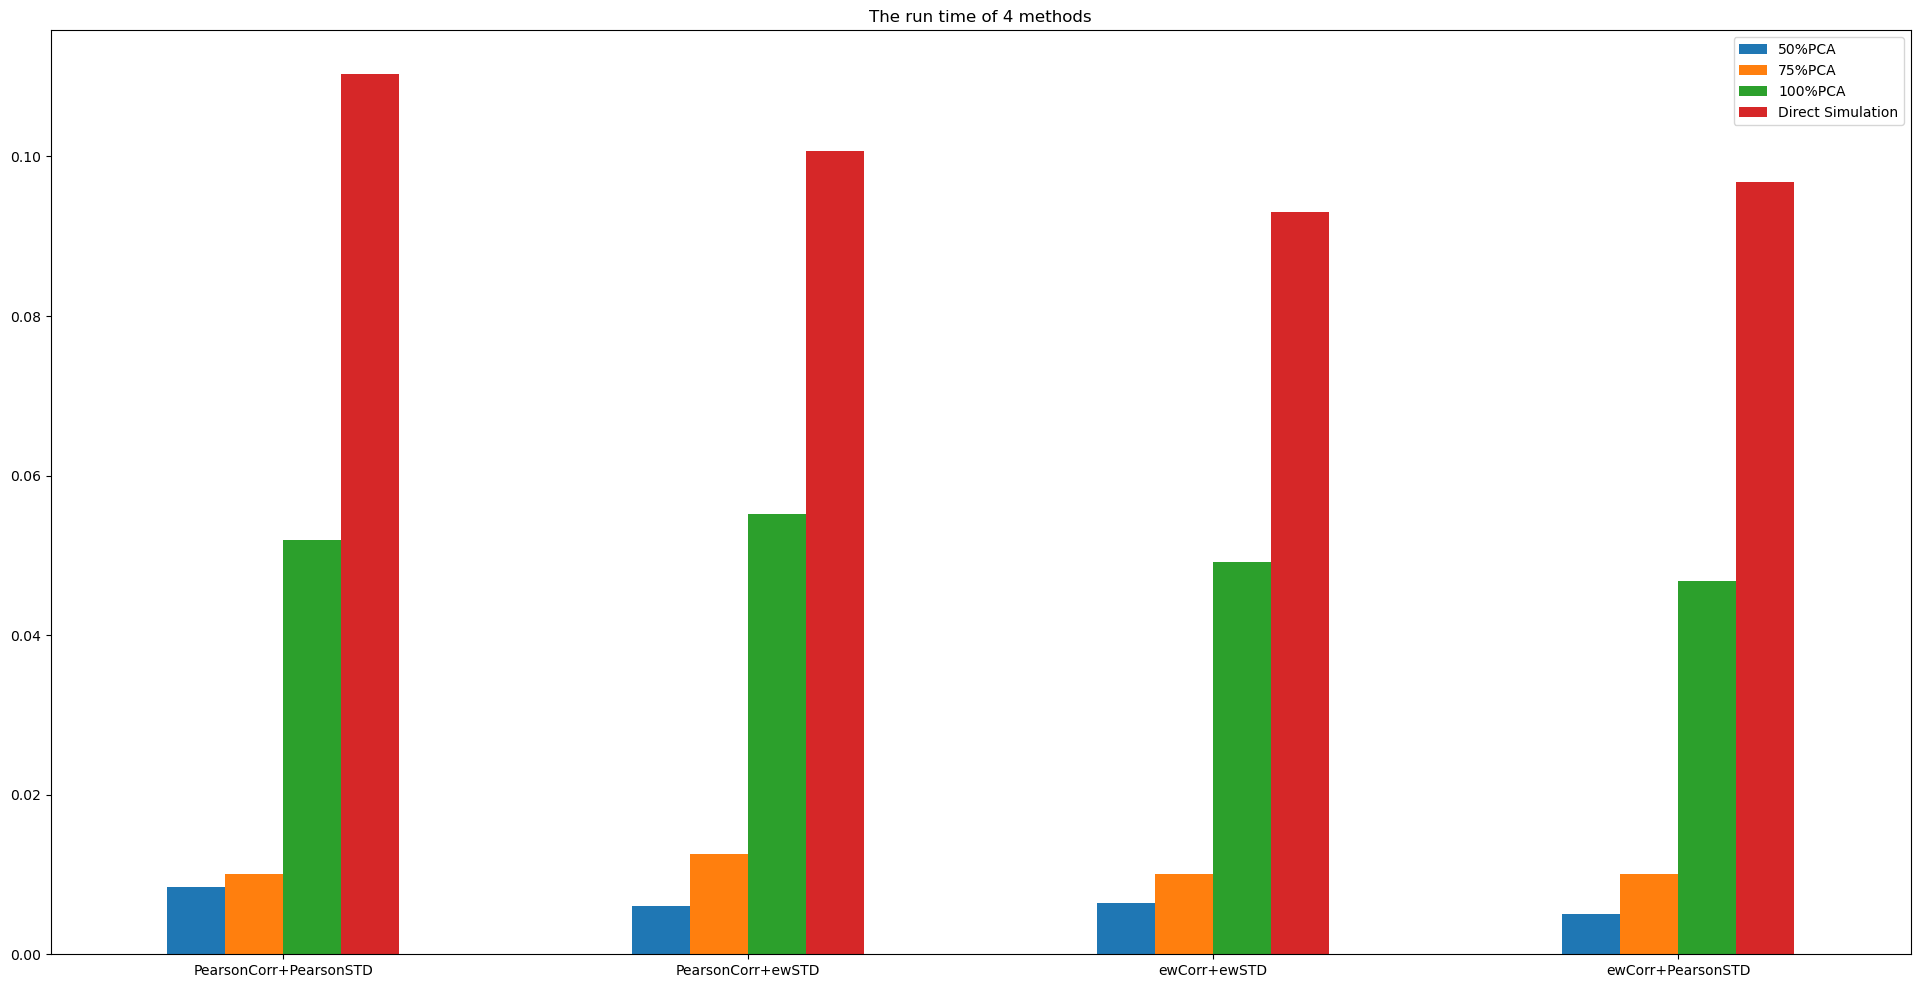

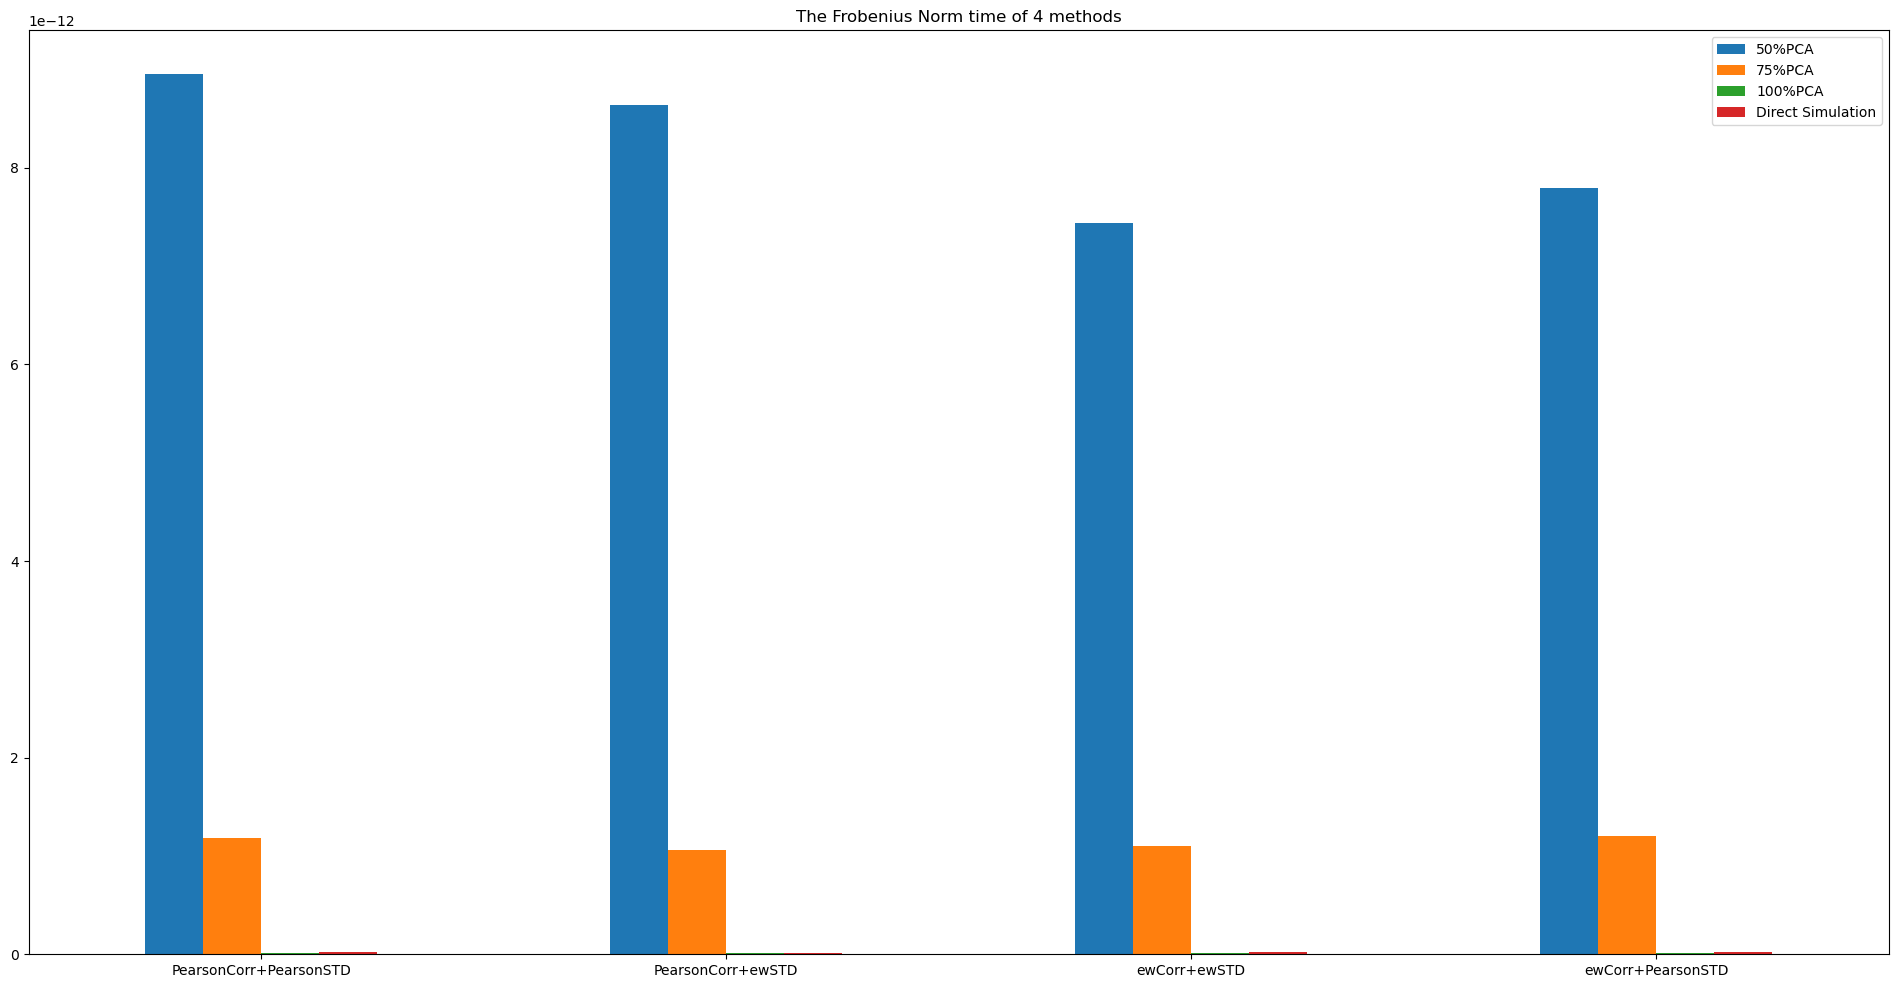

In [586]:
x_label=['PearsonCorr+PearsonSTD','PearsonCorr+ewSTD','ewCorr+ewSTD','ewCorr+PearsonSTD']

F=[]
T=[]

for i in range(len(New_cov)):
    
    print("The result of "+x_label[i]+" is showing below:")
    

    dt,pt=compare_run_time(New_cov[i],25000)
    tmp=[]
    tmp.append(dt)
    tmp=pt+tmp
    T.append(tmp)
    
    df,pf=compare_Frob_Norm(New_cov[i],25000)
    tmp2=[]
    tmp2.append(df)
    tmp2=pf+tmp2
    F.append(tmp2)
    
stick = ["50%PCA", "75%PCA", "100%PCA","Direct Simulation"]


pd.DataFrame(T,index=x_label,columns = stick).plot.bar(rot = 0,figsize=(24, 12))
plt.title("The run time of 4 methods")

pd.DataFrame(F,index=x_label,columns = stick).plot.bar(rot = 0,figsize=(24, 12))
plt.title("The Frobenius Norm time of 4 methods")
